In [ ]:
import numpy as np
import cv2
import scipy.io as scio
from scipy import signal
import yaml
import skimage
from PIL import Image

import sys
import os
import glob

import matplotlib.pyplot as plt

In [33]:
filenames = glob.glob('../defocuscamdata/calibration_data/psfs/*.png')

%ls ../defocuscamdata/calibration_data/psfs/
filenames.sort()

bot_left_psf.png    middle_left_psf.png   psf_parts_3.png     top_right_psf.png
bot_middle_psf.png  middle_right_psf.png  psf_parts_4.png
bot_right_psf.png   psf_parts_1.png       top_left_psf.png
filter_shape.png    psf_parts_2.png       top_middle_psf.png


In [34]:
keys = [file[:-3] for file in filenames if 'middle' in file or 'bot' in file or 'top' in file]
names = [file.split("/")[-1] for file in filenames if 'middle' in file or 'bot' in file or 'top' in file]
images = [np.asarray(Image.open(file)) for file in filenames if 'middle' in file or 'bot' in file or 'top' in file]

In [35]:

names

['bot_left_psf.png',
 'bot_middle_psf.png',
 'bot_right_psf.png',
 'middle_left_psf.png',
 'middle_right_psf.png',
 'top_left_psf.png',
 'top_middle_psf.png',
 'top_right_psf.png']

In [36]:
print(len(keys))
print(keys)

8
['../defocuscamdata/calibration_data/psfs/bot_left_psf.', '../defocuscamdata/calibration_data/psfs/bot_middle_psf.', '../defocuscamdata/calibration_data/psfs/bot_right_psf.', '../defocuscamdata/calibration_data/psfs/middle_left_psf.', '../defocuscamdata/calibration_data/psfs/middle_right_psf.', '../defocuscamdata/calibration_data/psfs/top_left_psf.', '../defocuscamdata/calibration_data/psfs/top_middle_psf.', '../defocuscamdata/calibration_data/psfs/top_right_psf.']


In [37]:
images = [im/np.max(im) for im in images]

### cropping

In [38]:
def get_circular_kernel(diameter):

    mid = (diameter - 1) / 2
    distances = np.indices((diameter, diameter)) - np.array([mid, mid])[:, None, None]
    kernel = ((np.linalg.norm(distances, axis=0) - mid) <= 0).astype(int)

    return kernel

In [39]:
kernel = get_circular_kernel(11)

In [40]:
im_conv = [signal.correlate(im, kernel, mode = 'same') for im in images]

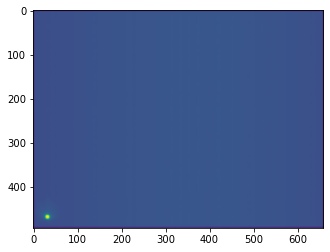

In [41]:
plt.imshow(im_conv[0])

In [42]:
maxlocs_conv = [cv2.minMaxLoc(im)[-1] for im in im_conv]
maxlocs = [cv2.minMaxLoc(im)[-1] for im in images]

In [43]:
crop_size = 24
print([(maxlocs_conv[i][1]-crop_size//2, maxlocs_conv[i][1]+crop_size//2, 
                     maxlocs_conv[i][0]-crop_size//2, maxlocs_conv[i][0]+crop_size//2)
       for i in range(len(maxlocs_conv))])

[(456, 480, 20, 44), (461, 485, 330, 354), (461, 485, 620, 644), (233, 257, 9, 33), (260, 284, 620, 644), (17, 41, 17, 41), (0, 24, 273, 297), (17, 41, 620, 644)]


In [44]:
print([(maxlocs[i][1]-crop_size//2,maxlocs[i][1]+crop_size//2, 
                     maxlocs[i][0]-crop_size//2,maxlocs[i][0]+crop_size//2) for i in range(len(maxlocs))])

[(456, 480, 20, 44), (461, 485, 330, 354), (462, 486, 620, 644), (233, 257, 9, 33), (261, 285, 620, 644), (18, 42, 17, 41), (1, 25, 273, 297), (18, 42, 619, 643)]


In [45]:
centered_images = [im[maxlocs_conv[i][1]-crop_size//2:maxlocs_conv[i][1]+crop_size//2, 
                     maxlocs_conv[i][0]-crop_size//2:maxlocs_conv[i][0]+crop_size//2] for i, im in enumerate(images)]

In [46]:
print([im.shape for im in centered_images])

[(24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24)]


### vis


In [47]:
psf_stack = np.stack(centered_images)

std_mat = np.std(psf_stack, 0)
var_mat = np.var(psf_stack, 0)
mean_mat = np.mean(psf_stack, 0)

In [53]:
names = [name[:-4] for name in names]
names = names[0:4] + ["variance"] + names[4:]

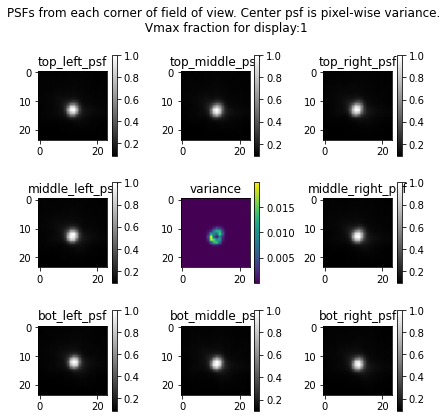

In [73]:
vmax_frac = 1
fig, ax = plt.subplots(3,3,figsize=(6,6))
for i in range(3):
    for j in range(3):
        if i == 1 and j == 1:
            im = ax[i][j].imshow(var_mat, vmax = np.max(var_mat)*vmax_frac)
            fig.colorbar(im, ax=ax[i][j])
        else:
            if (2-i)*3 + j < 4:
                im = ax[i][j].imshow(centered_images[(2-i)*3+j], cmap = 'gray', vmax = np.max(centered_images)*(vmax_frac))
                fig.colorbar(im, ax=ax[i][j])
            else:
                im = ax[i][j].imshow(centered_images[(2-i)*3+j - 1], cmap = 'gray', vmax = np.max(centered_images)*(vmax_frac))
                fig.colorbar(im, ax=ax[i][j])

        ax[i][j].set_title(names[(2-i)*3+j])
plt.suptitle(f"PSFs from each corner of field of view. Center psf is pixel-wise variance.\n Vmax fraction for display:{vmax_frac}")
plt.tight_layout()
plt.show()

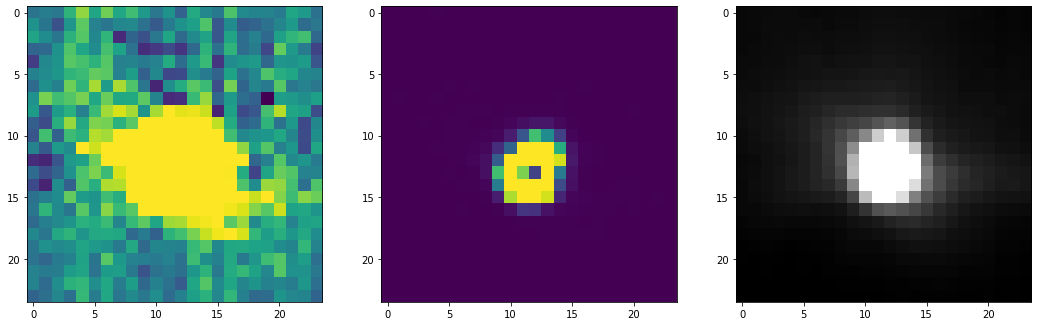

In [18]:
fig, ax = plt.subplots(1,3, figsize = (18,6))
ax[0].imshow(std_mat, vmax = np.max(var_mat)/3)
ax[1].imshow(var_mat, vmax = np.max(var_mat)/3)
ax[2].imshow(mean_mat, cmap ='gray', vmax = np.max(mean_mat)/3)